In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [287]:
# locations that we are interested in
locations_of_interest = ['Quebec', 'Ontario']

In [288]:
# Load the ev raw data
ev_data_base = pd.read_csv('data/ev.csv')

# convert the REF_DATE to a datetime object
ev_data_base['REF_DATE'] = pd.to_datetime(ev_data_base['REF_DATE'])
ev_data_base.rename(columns={'REF_DATE': 'date', 'VALUE': 'value'}, inplace=True)
all_locations = ev_data_base["GEO"].unique()
# make sure no typo
assert all([loc in all_locations for loc in locations_of_interest]), "One of the locations is not in the data"

ev_data_qc = ev_data_base[ev_data_base['GEO'] == locations_of_interest[0]][['date', 'value']]
ev_data_on = ev_data_base[ev_data_base['GEO'] == locations_of_interest[1]][['date', 'value']]

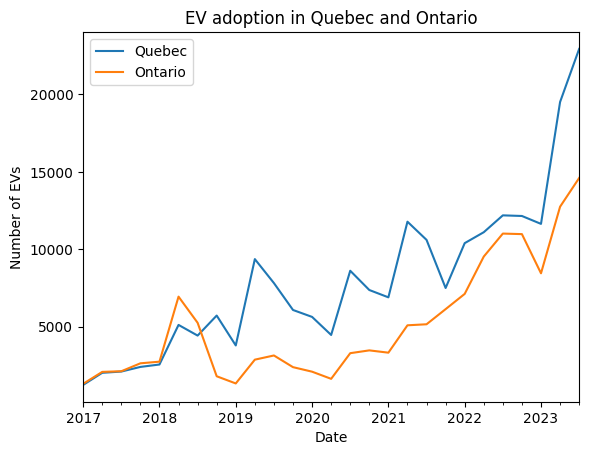

In [289]:
# time series plot of the ev adoption
fig, ax = plt.subplots()
ev_data_qc.plot(x='date', y='value', ax=ax, label=locations_of_interest[0])
ev_data_on.plot(x='date', y='value', ax=ax, label=locations_of_interest[1])
ax.set_ylabel('Number of EVs')
ax.set_xlabel('Date')
ax.set_title('EV adoption in Quebec and Ontario')
plt.show()


In [290]:
# load Quebec air quality data
qc_aq_16_18 = pd.read_csv('data/Quebec/2016-2018.csv')
qc_aq_19_21 = pd.read_csv('data/Quebec/2019-2021.csv')
qc_aq_22_24 = pd.read_csv('data/Quebec/2022-2024.csv')

qc_aq_base = pd.concat([qc_aq_16_18, qc_aq_19_21, qc_aq_22_24])
qc_aq_base.rename(columns={
    'polluant': 'pollutant',
    'valeur': 'value',
    'heure': 'hour'}, inplace=True)

qc_aq_base['date'] = pd.to_datetime(qc_aq_base['date'])
# drop the station and hour columns
qc_aq_base = qc_aq_base.drop(columns=['stationId', 'hour'])
# filter out all the non-numeric values
qc_aq_base = qc_aq_base[qc_aq_base['value'].apply(lambda x: str(x).isnumeric())]

qc_aq={}
for pollutant in qc_aq_base['pollutant'].unique():
    qc_aq[pollutant] = qc_aq_base[qc_aq_base['pollutant'] == pollutant][['date', 'value']].groupby('date').mean()


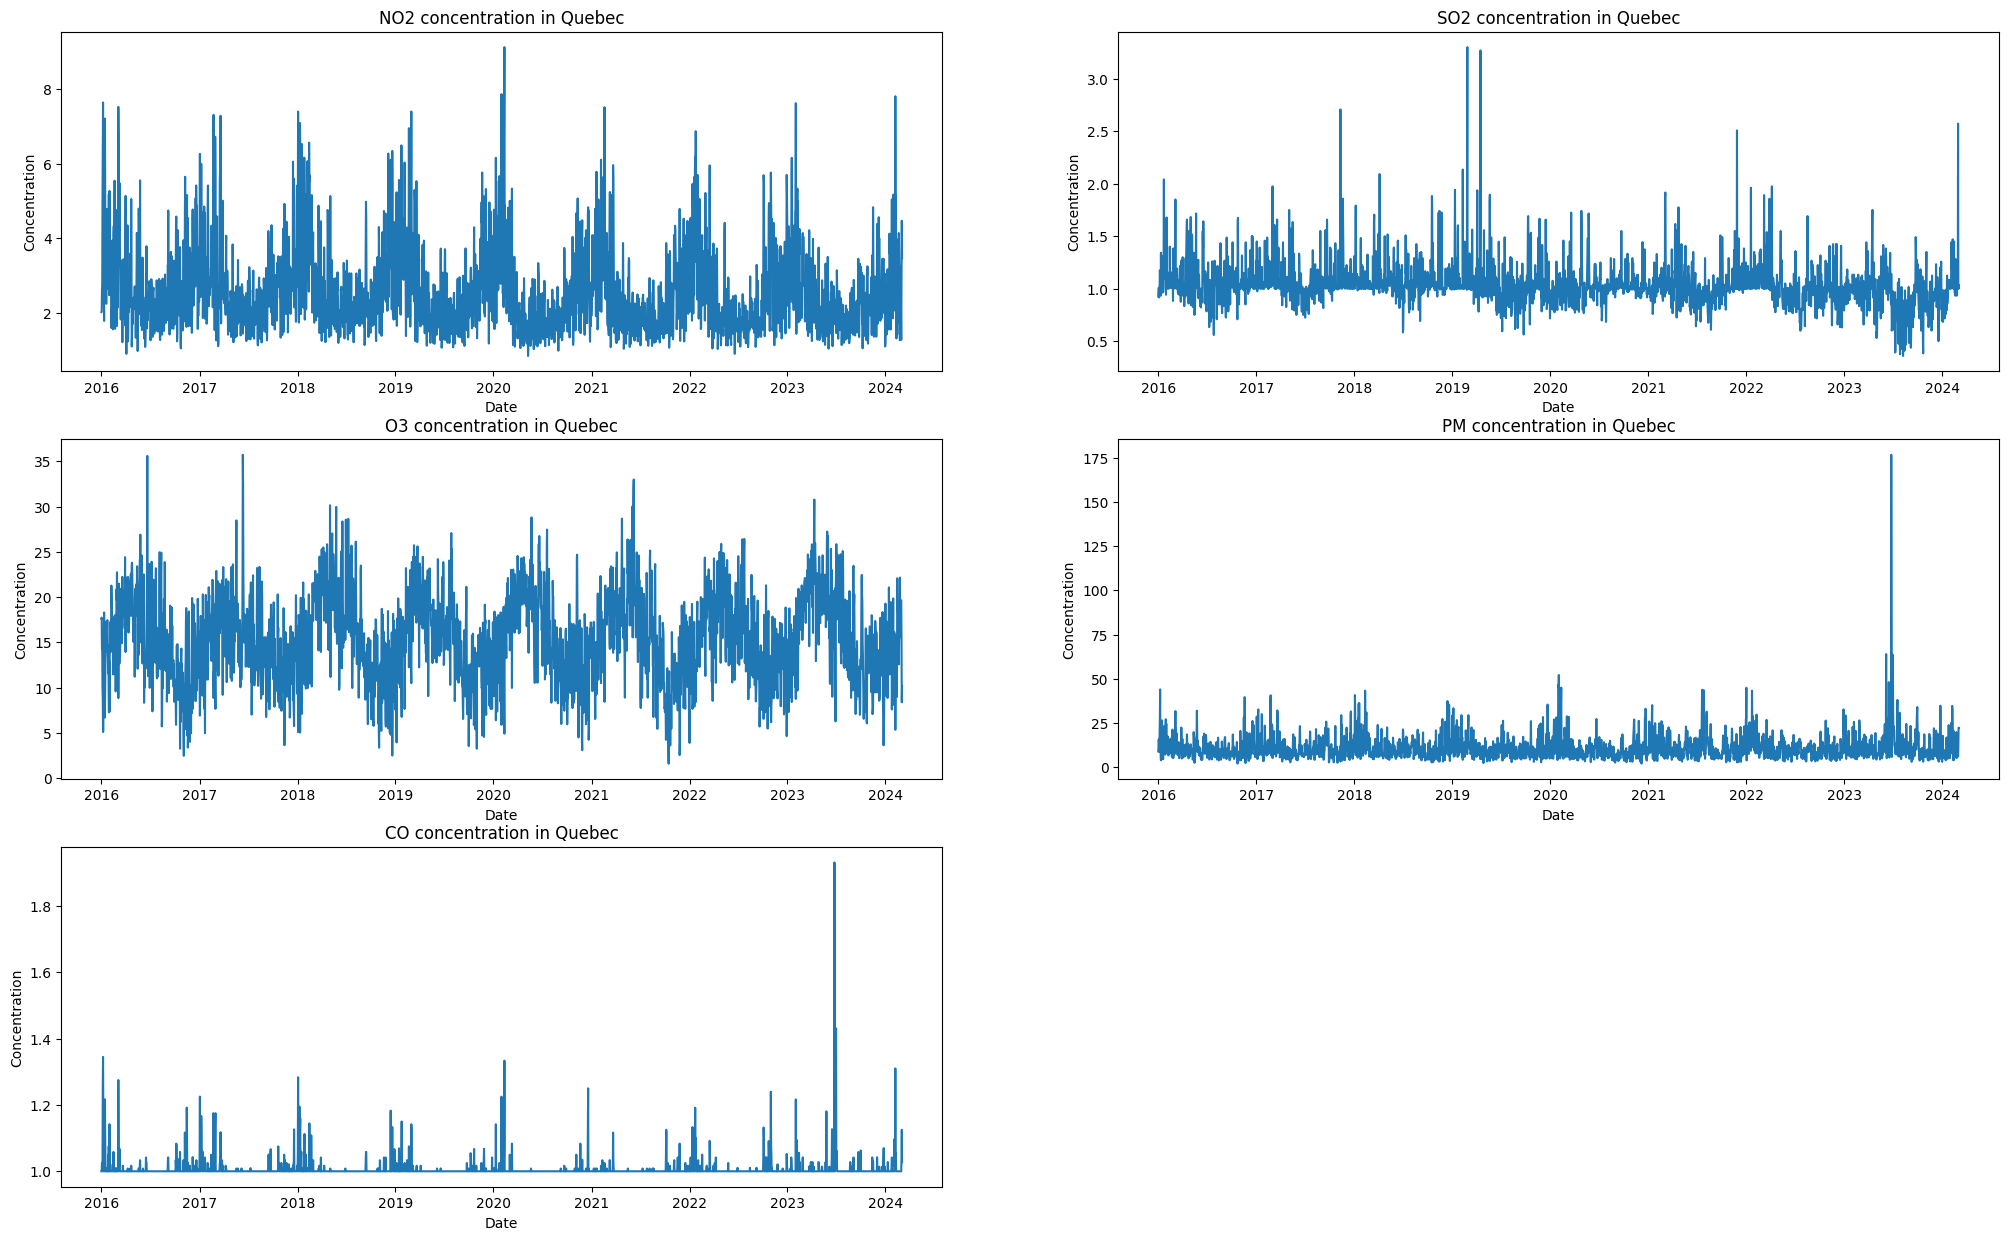

In [291]:
# qc_aq["NO2"]['value'] = np.ones(len(qc_aq["NO2"]['value']))
#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq[list(qc_aq.keys())[i]])
    plt.title(list(qc_aq.keys())[i] + ' concentration in Quebec')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()

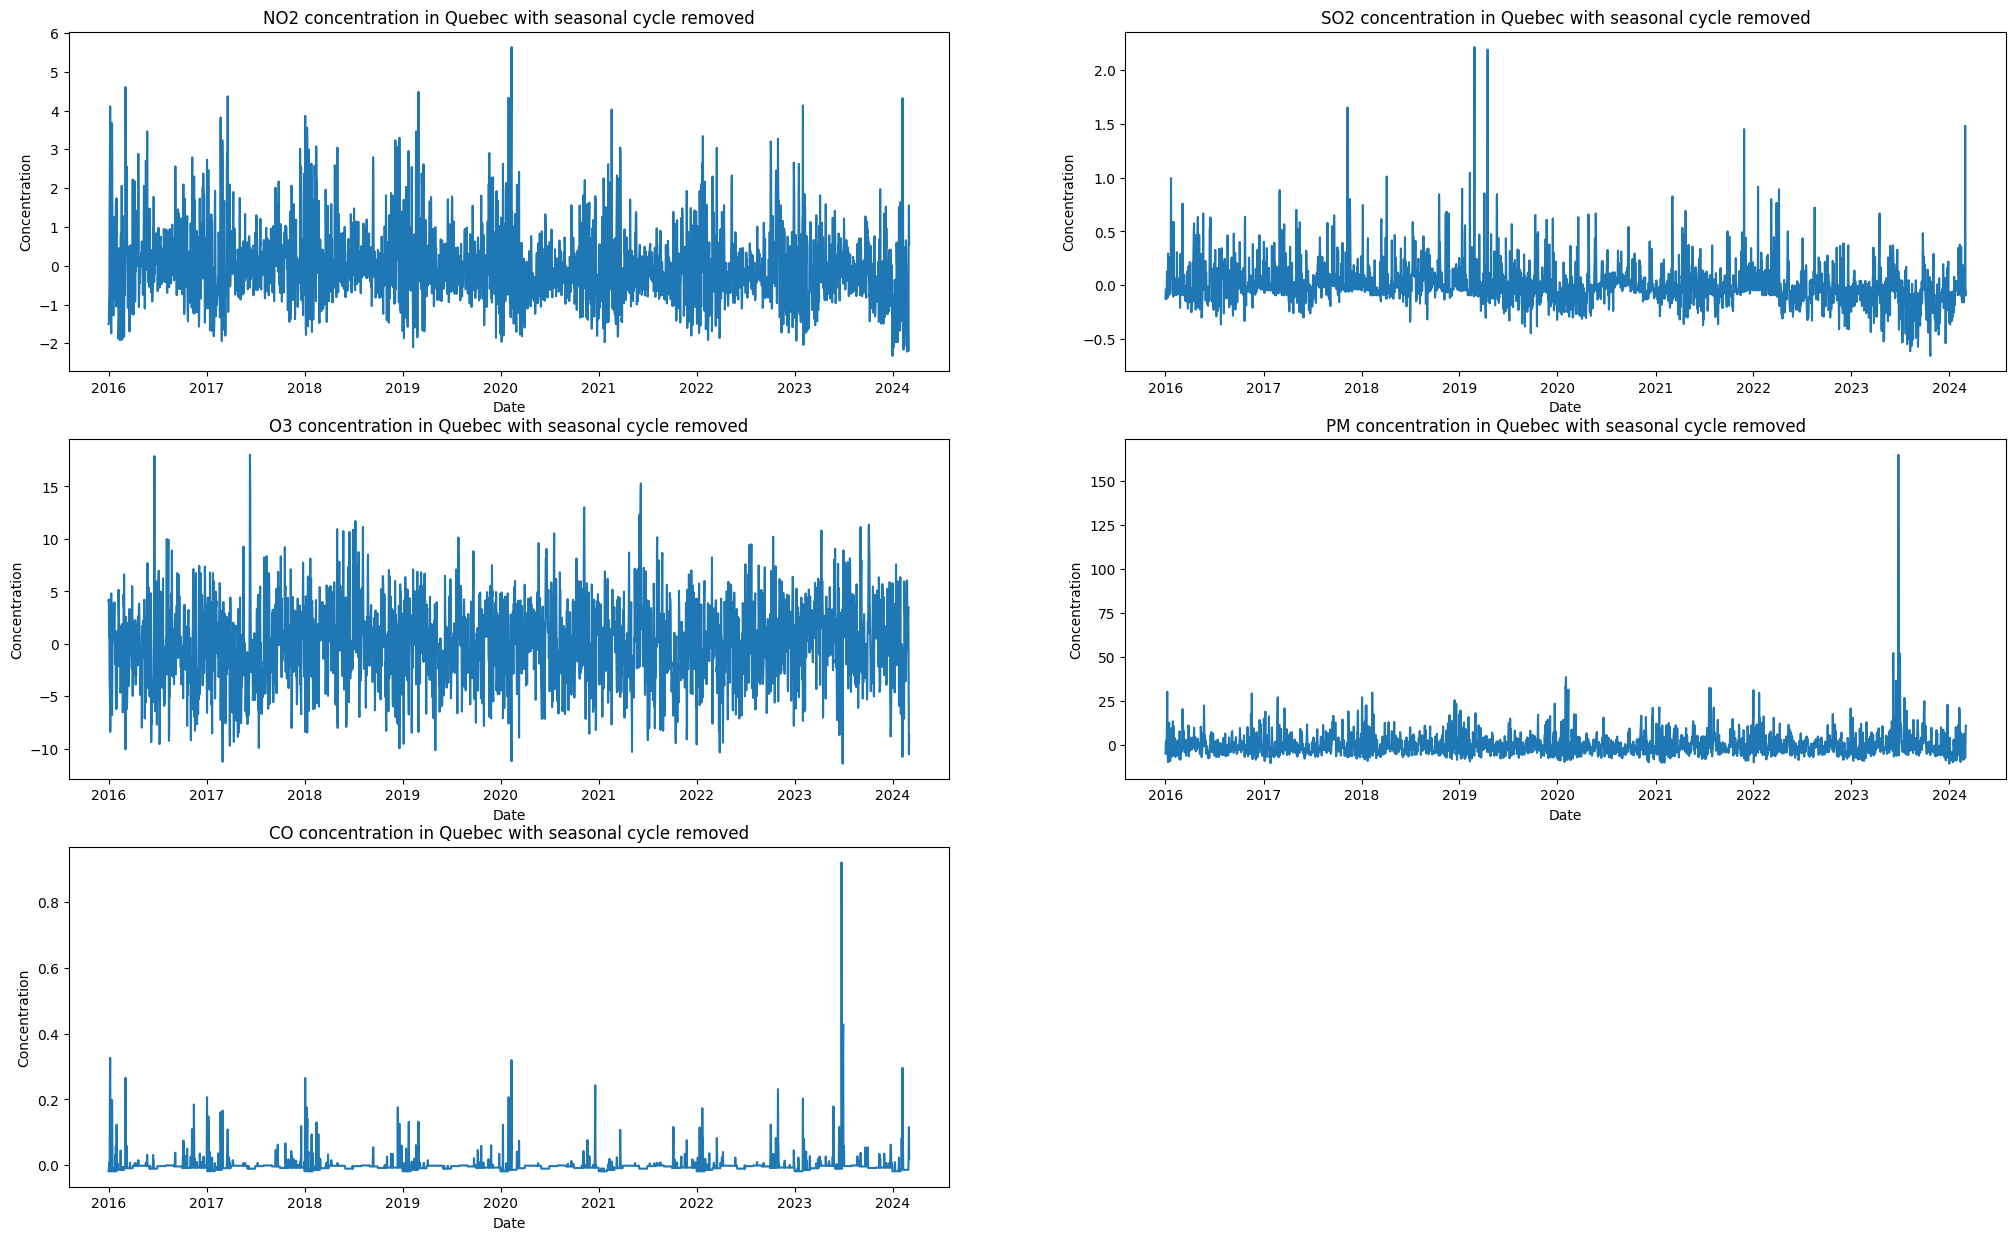

In [292]:
# clear up the seasonal cycle
def remove_seasonal_cycle(df):
    # df contains a date and a value column
    offsets = np.array(df.groupby(df.index.month).mean())
    for i in range(len(offsets)):
        df.loc[df.index.month == i+1, 'value'] -= offsets[i]
    return df

qc_aq_removed_seasonal_var = qc_aq.copy()

for pollutant in qc_aq_removed_seasonal_var:
    qc_aq_removed_seasonal_var[pollutant] = remove_seasonal_cycle(qc_aq_removed_seasonal_var[pollutant])

#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq_removed_seasonal_var)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq_removed_seasonal_var[list(qc_aq_removed_seasonal_var.keys())[i]])
    plt.title(list(qc_aq_removed_seasonal_var.keys())[i] + ' concentration in Quebec with seasonal cycle removed')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()

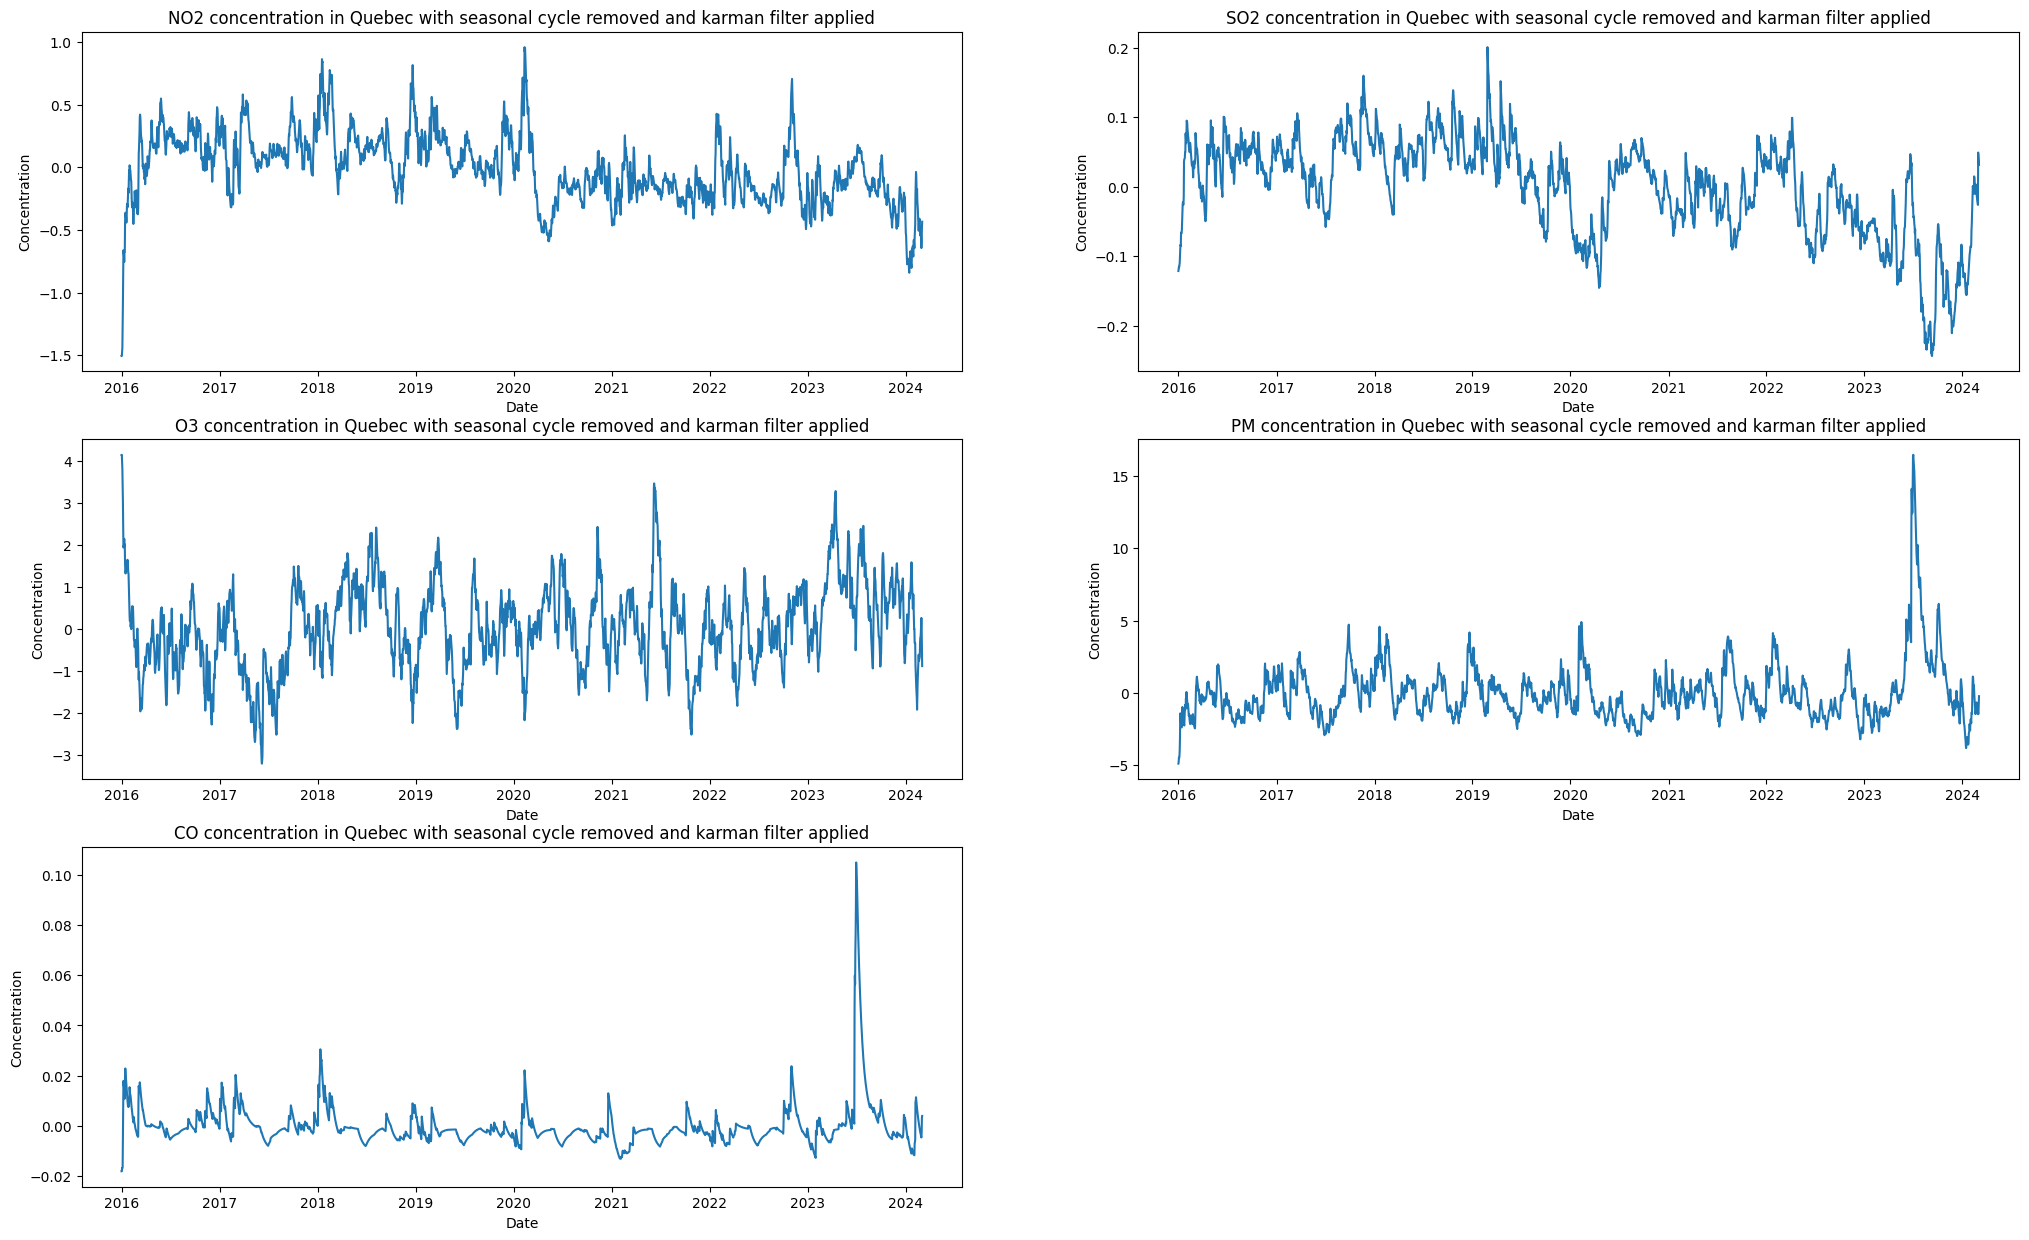

In [293]:
# apply karman filter to the qc_aq data
def after_karman(d, n_iter=1):
    d = np.array(d)
    for i in range(n_iter):
        last = d[0]
        for j in range(1, len(d)):
            d[j] = last*0.95 + d[j]*0.05
            last = d[j]
    return d

qc_aq_karman = qc_aq_removed_seasonal_var.copy()

for pollutant in qc_aq_karman:
    qc_aq_karman[pollutant]['value'] = after_karman(qc_aq_karman[pollutant]['value'])

#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq_karman)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq_karman[list(qc_aq_karman.keys())[i]])
    plt.title(list(qc_aq_karman.keys())[i] + ' concentration in Quebec with seasonal cycle removed and karman filter applied')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()
